In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import yfinance as yf

# Define the direct CSV download URLs for each series from FRED (website.

# FED balance sheet
url_walcl = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=WALCL"
# RRP balance held by NY FED
url_rrpon = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=RRPONTTLD"
# US Treasury General Account Balance
url_tga   = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=D2WLTGAL"

def download_data(url):
    """
    Downloads CSV data from the provided URL and returns a pandas DataFrame.
    Ensures the CSV has a 'DATE' column and converts it to datetime.
    """
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the download failed
    
    csv_text = response.text
    # Optionally, print the beginning of the CSV text for debugging:
    # print(csv_text[:200])
    
    data = StringIO(csv_text)
    
    # Read the CSV without parse_dates first so we can inspect the columns
    df = pd.read_csv(data)
    print(f"Downloaded columns from {url}: {df.columns.tolist()}")
    
    # Strip any whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Check that 'DATE' exists in the header; if not, raise an error.
    if 'observation_date' not in df.columns:
        raise ValueError(f"CSV from {url} does not contain a 'observation_date' column.")
    
    # Now convert the DATE column to datetime
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    return df

# Download each series
df_walcl = download_data(url_walcl)
df_rrpon = download_data(url_rrpon)
df_tga   = download_data(url_tga)


Downloaded columns from https://fred.stlouisfed.org/graph/fredgraph.csv?id=WALCL: ['observation_date', 'WALCL']
Downloaded columns from https://fred.stlouisfed.org/graph/fredgraph.csv?id=RRPONTTLD: ['observation_date', 'RRPONTTLD']
Downloaded columns from https://fred.stlouisfed.org/graph/fredgraph.csv?id=D2WLTGAL: ['observation_date', 'D2WLTGAL']


TypeError: Index does not support mutable operations


Filtered FRED Data (from 09/2014 onward):
                  Fed_Balance_Sheet  Reverse_Repo  Treasury_GA  \
observation_date                                                 
2014-09-17                  4449588      156936.0       123965   
2014-09-24                  4459050      162317.0       118905   
2014-10-01                  4450260      212481.0       126568   
2014-10-08                  4455403      182531.0        85309   
2014-10-15                  4474360      121915.0       101413   

                  USD_Liquidity_Index  
observation_date                       
2014-09-17                  4168687.0  
2014-09-24                  4177828.0  
2014-10-01                  4111211.0  
2014-10-08                  4187563.0  
2014-10-15                  4251032.0  


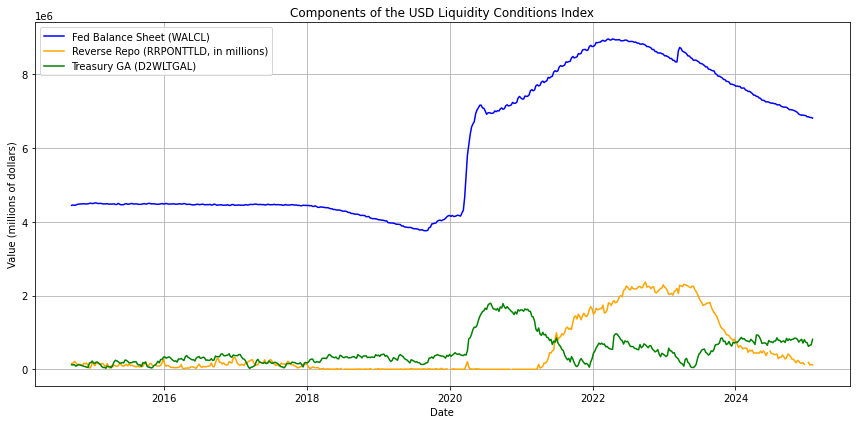

In [72]:
# Each CSV from FRED is usually two columns: 'observation_date' and the series value.
# For clarity, rename the value columns based on the series.
df_walcl.rename(columns={df_walcl.columns[1]: 'Fed_Balance_Sheet'}, inplace=True)
df_rrpon.rename(columns={df_rrpon.columns[1]: 'Reverse_Repo'}, inplace=True)
df_tga.rename(columns={df_tga.columns[1]: 'Treasury_GA'}, inplace=True)

# Merge the data on the 'DATE' column using an inner join so that only dates common to all series remain.
df = pd.merge(df_walcl[['observation_date', 'Fed_Balance_Sheet']],
              df_rrpon[['observation_date', 'Reverse_Repo']],
              on='observation_date', how='inner')
df = pd.merge(df, df_tga[['observation_date', 'Treasury_GA']], on='observation_date', how='inner')

# Convert Reverse Repo from billions to millions by multiplying by 1000.
df['Reverse_Repo'] = df['Reverse_Repo'] * 1000

# Calculate the USD Liquidity Conditions Index.
# USD Liquidity Index = Fed's Balance Sheet - Reverse Repo - Treasury GA
df['USD_Liquidity_Index'] = df['Fed_Balance_Sheet'] - df['Reverse_Repo'] - df['Treasury_GA']

### Filter the data to only include observations from 2012 onward.
df = df[df['observation_date'] >= pd.to_datetime('2014-09-17')]
# df = df[df['observation_date'] <= pd.to_datetime('2023-01-01')]

df['USD_Liquidity_Index'] = df['USD_Liquidity_Index'].ffill()

# Optionally, set 'observation_date' as the DataFrame index.
df.set_index('observation_date', inplace=True)

print("\nFiltered FRED Data (from 09/2014 onward):")
print(df.head())

# Plot all three series on the same figure.
plt.figure(figsize=(12, 6))
plt.plot(df.index.to_numpy(), df['Fed_Balance_Sheet'].to_numpy(), label='Fed Balance Sheet (WALCL)', color='blue')
plt.plot(df.index.to_numpy(), df['Reverse_Repo'].to_numpy(), label='Reverse Repo (RRPONTTLD, in millions)', color='orange')
plt.plot(df.index.to_numpy(), df['Treasury_GA'].to_numpy(), label='Treasury GA (D2WLTGAL)', color='green')
plt.xlabel('Date')
plt.ylabel('Value (millions of dollars)')
plt.title('Components of the USD Liquidity Conditions Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


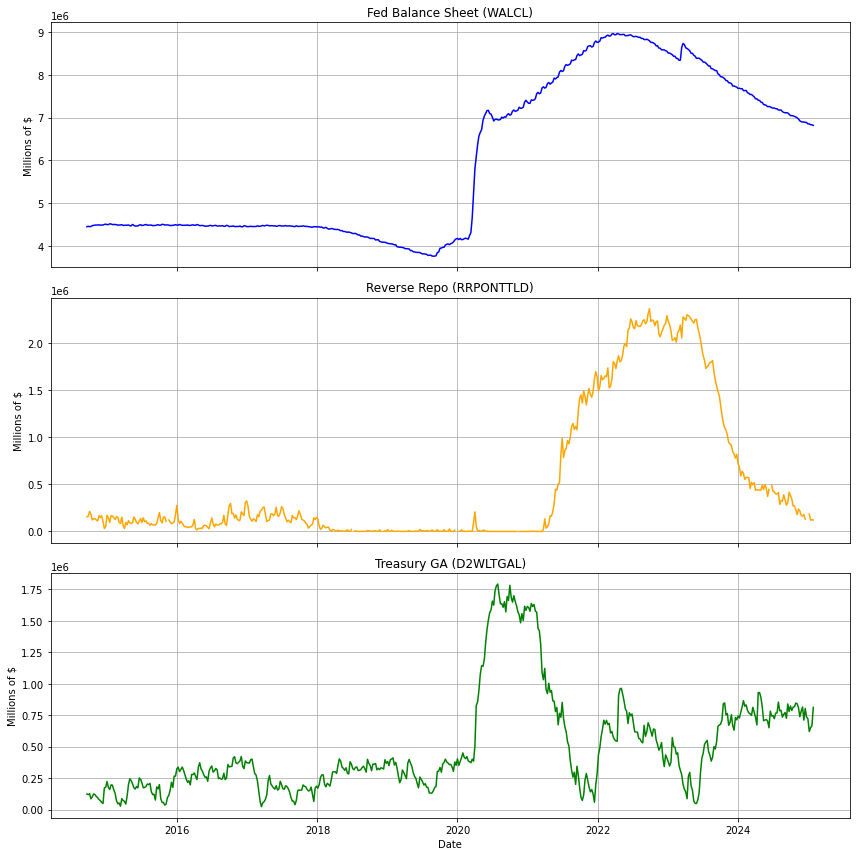

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot Fed Balance Sheet
axs[0].plot(df.index.to_numpy(), df['Fed_Balance_Sheet'].to_numpy(), color='blue')
axs[0].set_title('Fed Balance Sheet (WALCL)')
axs[0].set_ylabel('Millions of $')
axs[0].grid(True)

# Plot Reverse Repo
axs[1].plot(df.index.to_numpy(), df['Reverse_Repo'].to_numpy(), color='orange')
axs[1].set_title('Reverse Repo (RRPONTTLD)')
axs[1].set_ylabel('Millions of $')
axs[1].grid(True)

# Plot Treasury GA
axs[2].plot(df.index.to_numpy(), df['Treasury_GA'].to_numpy(), color='green')
axs[2].set_title('Treasury GA (D2WLTGAL)')
axs[2].set_ylabel('Millions of $')
axs[2].set_xlabel('Date')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [74]:

btc_data = yf.download("BTC-USD", start="2014-09-01", progress=False)


btc_data


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2025-01-29,103703.210938,104750.804688,101283.820312,101317.523438,47432049818
2025-01-30,104735.304688,106418.765625,103321.648438,103709.335938,41915744521


In [75]:
# We'll use the Adjusted Close price.
btc = btc_data[['Close']].copy()
btc.rename(columns={'Close': 'BTC_Price'}, inplace=True)

print("\nBTC Data (first 5 rows):")
print(btc.head())


BTC Data (first 5 rows):
Price        BTC_Price
Ticker         BTC-USD
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014


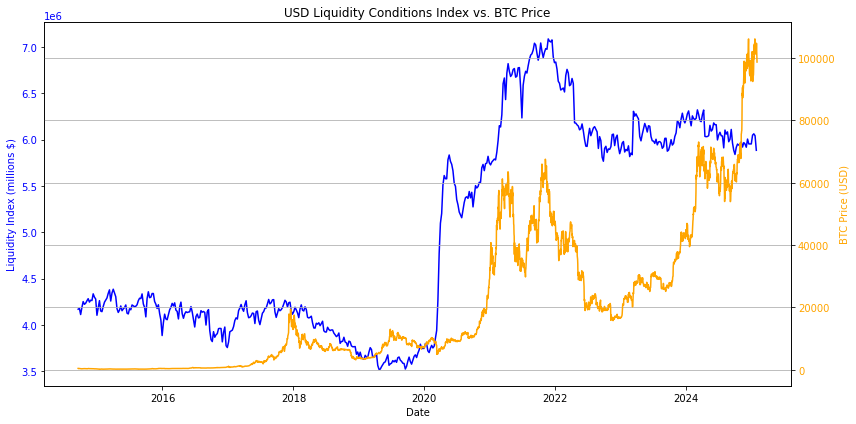

In [76]:
# ------------------------------------------------
# Step 3. Plot the USD Liquidity Index and BTC Price
# ------------------------------------------------
# Because the scales differ (liquidity index in millions vs. BTC price in dollars),
# we plot them using two y-axes.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the USD Liquidity Conditions Index on the left y-axis.
ax1.plot(df.index.to_numpy(), df['USD_Liquidity_Index'].to_numpy(), label='USD Liquidity Index (millions $)', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Liquidity Index (millions $)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the BTC price.
ax2 = ax1.twinx()
ax2.plot(btc.index.to_numpy(), btc['BTC_Price'].to_numpy(), label='BTC Price (USD)', color='orange')
ax2.set_ylabel('BTC Price (USD)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('USD Liquidity Conditions Index vs. BTC Price')
fig.tight_layout()
plt.grid()
plt.show()

In [77]:
import numpy as np

# Calculate daily returns (percentage change) for BTC and the liquidity index
btc['BTC_Return'] = btc['BTC_Price'].pct_change()
df['Liquidity_Change'] = df['USD_Liquidity_Index'].pct_change()

# Drop NA values that result from the percentage change calculation
combined = pd.concat([btc['BTC_Return'], df['Liquidity_Change']], axis=1).dropna()

# Calculate the Pearson correlation coefficient
correlation = combined['BTC_Return'].corr(combined['Liquidity_Change'])
print(f"Correlation between BTC returns and liquidity index returns: {correlation:.4f}")

Correlation between BTC returns and liquidity index returns: 0.0389
